# Image Caption Generator using Flicker8k and Deep Learning


# Import Modules

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
BASE_DIR = 'Images'
WORKING_DIR = '/Intelligent Systems Project'

# Feature Extraction 

In [3]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [3]:
# extract features from image uisng VGG16
features = {}
directory = "Images"

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [10]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [4]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

# Load Caption Data

In [5]:
with open('captions.txt', 'r') as f:
    next(f)
    captions_doc = f.read()

In [6]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [7]:
len(mapping)

8091

# Data Preprocessing

In [8]:
def clean(mapping):
    # iterate over image id and caption for each image
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            # replace the processed caption at the corresponding index
            captions[i] = caption

In [9]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [10]:
# preprocess the text
clean(mapping)

In [11]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [12]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)


In [13]:
len(all_captions)

40455

In [14]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [15]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [16]:
vocab_size

8485

In [17]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

# Train Test Split

In [18]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]
split

7281

In [20]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

# Model Creation

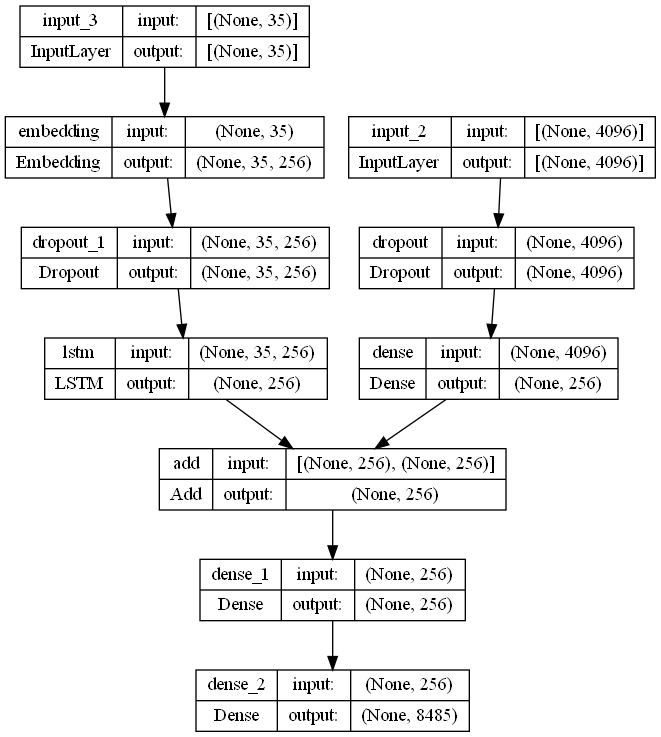

In [21]:
# encoder model

# image feature layerws
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers, consists of embedding, dropout, and LSTM
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# model concatination, we don't need to use CNN for the decoding model because we already did feature extraction so we can use VGG
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [22]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator to avoid crashing the session while training
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 183s 806ms/step - loss: 2.1954


In [33]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 256)      2172160     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_2[0][0]']                
                                                                                            

In [23]:
# save the model
model.save(WORKING_DIR+'/thefruitsofmylabor.h5')

In [18]:
# load the model
saved_model = load_model('thefruitsofmylabor.h5')
saved_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 256)      2172160     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_2[0][0]']                
                                                                                            

# Generate Captions for the Image

In [19]:
# convert image id into a word, all the words are in index form so we need to transform them
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [20]:
# generate caption for an image, basically how this works is that it predicts each word in the sequence given an image using the model. yhat is used as 
# the highest probability word that results from the prediction that is then added on to the resulting caption. This is repeated until the end seq tag is reached
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [36]:
# using BLEU score to evaluate the model, basically uses the actual captions of the image and compares them to the predicted caption output of the model
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\tensor_env\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\ProgramData\anaconda3\envs\tensor_env\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU-1: 0.411765
BLEU-2: 0.160422
BLEU-1: 0.440000
BLEU-2: 0.195604
BLEU-1: 0.435897
BLEU-2: 0.190591
BLEU-1: 0.425532
BLEU-2: 0.172303
BLEU-1: 0.421053
BLEU-2: 0.155857
BLEU-1: 0.421875
BLEU-2: 0.147720
BLEU-1: 0.450704
BLEU-2: 0.187647
BLEU-1: 0.467532
BLEU-2: 0.217786
BLEU-1: 0.444444
BLEU-2: 0.195982
BLEU-1: 0.454328
BLEU-2: 0.202393
BLEU-1: 0.462072
BLEU-2: 0.209535
BLEU-1: 0.479065
BLEU-2: 0.209980
BLEU-1: 0.480379
BLEU-2: 0.223267
BLEU-1: 0.461887
BLEU-2: 0.205966
BLEU-1: 0.455128
BLEU-2: 0.196810
BLEU-1: 0.462954
BLEU-2: 0.210766
BLEU-1: 0.476670
BLEU-2: 0.228853
BLEU-1: 0.470092
BLEU-2: 0.231568
BLEU-1: 0.466779
BLEU-2: 0.240537
BLEU-1: 0.471155
BLEU-2: 0.254305
BLEU-1: 0.475258
BLEU-2: 0.252260
BLEU-1: 0.480614
BLEU-2: 0.252755
BLEU-1: 0.493706
BLEU-2: 0.269425
BLEU-1: 0.495852
BLEU-2: 0.273442
BLEU-1: 0.509446
BLEU-2: 0.296469
BLEU-1: 0.516515
BLEU-2: 0.308291
BLEU-1: 0.508867
BLEU-2: 0.300420
BLEU-1: 0.505163
BLEU-2: 0.295280
BLEU-1: 0.509989
BLEU-2: 0.297506
BLEU-1: 0.5241

# Visualization

In [34]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "44129946_9eeb385d77.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join("Images", image_name)
    #image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(saved_model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    #plt.imshow(image)

---------------------Actual---------------------
startseq brown dog is jumping up at woman who is wearing brown skirt endseq
startseq golden retriever is excitedly greeting woman as little dog walks towards the camera endseq
startseq tan dog jumping up at woman in skirt and black and tan dog walking away endseq
startseq yellow dog jumps to greet woman endseq
startseq one dog is jumping at the lady while the other walks away endseq
--------------------Predicted--------------------
startseq dog is jumping on his hind legs endseq


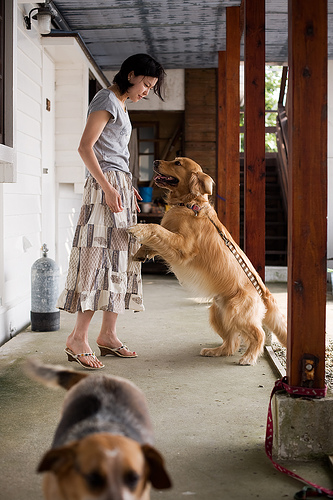

In [37]:
image_sample = '1597557856_30640e0b43.jpg'
img = Image.open('Images/1597557856_30640e0b43.jpg')
generate_caption(image_sample)
display(img)

---------------------Actual---------------------
startseq "a downhill skier with backpack on background of mountains and wispy clouds ." endseq
startseq man in orange is skiing down snow-covered hill endseq
startseq skier in red jacket and yellow backpack skis down snow slope endseq
startseq skier going down the snowy hill endseq
startseq person with two ski poles skiing down snowy hill endseq
--------------------Predicted--------------------
startseq skier in red jacket is skiing down snow covered mountain endseq


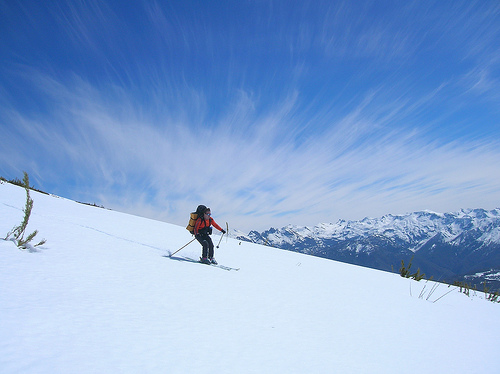

In [38]:
image_sample = '1472053993_bed67a3ba7.jpg'
img = Image.open('Images/1472053993_bed67a3ba7.jpg')
generate_caption(image_sample)
display(img)

---------------------Actual---------------------
startseq brown dog brings up some dust as he runs around field endseq
startseq dog and dust storm endseq
startseq dog and sand blowing in the wind endseq
startseq dog in sandy area with the sand stirred up into the air and several plants in the background endseq
startseq dog kicking up dirt endseq
--------------------Predicted--------------------
startseq dog is running through field endseq


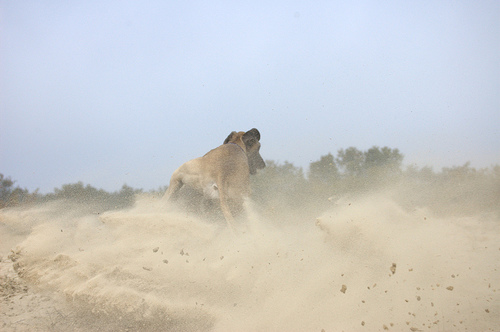

In [39]:
image_sample = '1541272333_1624b22546.jpg'
img = Image.open('Images/1541272333_1624b22546.jpg')
generate_caption(image_sample)
display(img)


---------------------Actual---------------------
startseq boxer punches boxer in the face endseq
startseq fighter attempts to kick another fighter while the other fighter blocks his kick endseq
startseq kickboxer jumping for kick endseq
startseq two boxers are in the ring endseq
startseq "two men kickbox in ring one man punching the other ." endseq
--------------------Predicted--------------------
startseq two girls are playing volleyball on stage endseq


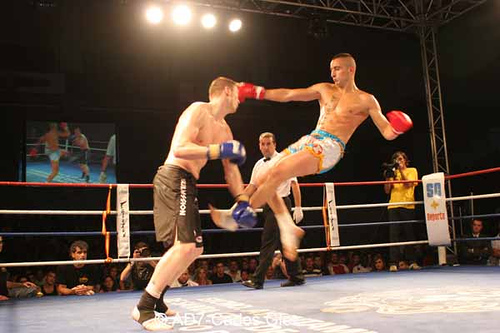

In [40]:
image_sample = '1991806812_065f747689.jpg'
img = Image.open('Images/1991806812_065f747689.jpg')
generate_caption(image_sample)
display(img)